In [1]:
# primary settings
state = 'AL'
level = 'tract'
deviation = 0.01  # 1.00%

minority = 'Black'
max_split_counties = 1

from number_of_districts import congressional_districts_2020
k = congressional_districts_2020[state]

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

from gerrychain import Graph
G = Graph.from_json( filepath + filename )

# total population
for i in G.nodes:
    G.nodes[i]['TOTPOP'] = G.nodes[i]['P0010001'] 

In [3]:
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k

import math
L = math.ceil(  ideal_population * (1-deviation/2) )
U = math.floor( ideal_population * (1+deviation/2) )

print("Using k, L, U =",k,L,U)

Using k, L, U = 7 714166 721342


In [4]:
# bidirected version of graph G
import networkx as nx
DG = nx.DiGraph(G)
DG._L = L
DG._U = U

In [5]:
# build optimization model to minimize inverse PP score
from single_district import build_single_district_mip 

m = build_single_district_mip( DG, minority=minority, max_split_counties=max_split_counties)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-11
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter IntFeasTol to value 1e-07


In [6]:
# solve the MISOCP
m.optimize(m._callback)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10977 rows, 9672 columns and 45412 nonzeros
Model fingerprint: 0xacea18a2
Model has 1 quadratic constraint
Variable types: 6 continuous, 9666 integer (9666 binary)
Coefficient statistics:
  Matrix range     [3e-05, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 0 rows and 1 columns
Presolve time: 0.06s
Presolved: 10977 rows, 9671 columns, 45411 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 9668 integer (9666 binary)

Root relaxation: objective 0.000000e+00, 6060 iterations, 0.33 seconds (0.34 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

In [7]:
print("The inverse Polsby-Popper score is",m.objval)
print("The Polsby-Popper score is",1.0/m.objval)

# retrieve the district and its population
district = [ i for i in G.nodes if m._x[i].x > 0.5 ] 
population = sum( G.nodes[i]["TOTPOP"] for i in district )

print("\nDistrict has this many nodes:",len(district))
print("And a population of:",population)
print("Is it connected?",nx.is_connected(G.subgraph(district)))

The inverse Polsby-Popper score is 2.39963449975633
The Polsby-Popper score is 0.41673013123521296

District has this many nodes: 239
And a population of: 714234
Is it connected? True


In [8]:
try:
    minority
except NameError:
    minority = None

if minority is not None:
    vap = sum( DG.nodes[i]['VAP'] for i in district )
    mvap = sum( DG.nodes[i]['MVAP'] for i in district )
    print("The total voting age population is:",vap)
    print("Among the",minority,"population, the VAP is:",mvap)
    print("As a percentage, this is",round( 100 * mvap / vap, 2 ),"%")

The total voting age population is: 562696
Among the Black population, the VAP is: 281711
As a percentage, this is 50.06 %


In [9]:
# Let's draw the district on a map
from single_district import draw_single_district
filename = state + '_' + level + '.shp'

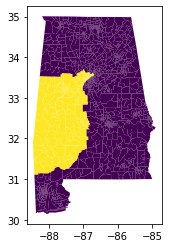

In [10]:
# State-wide view
draw_single_district( filepath, filename, G, district, zoom=False )

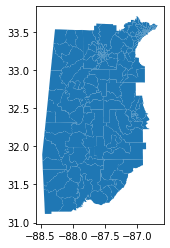

In [11]:
# District-only view
draw_single_district( filepath, filename, G, district, zoom=True )